In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1-np.exp(-0.5*(2*np.pi*1.3*1e-3*1e6    *350*1e-9)**2 *10),\
    1-np.exp(-0.5*(2*np.pi*1.3*1e-3*1e6    *350*1e-9   *10)**2)


(4.086426205596183e-05, 0.0004085674837920328)

In [2]:
1-np.exp(-0.5*(-4.2 *1e-6   *450)**2 *7.8),\
    1-np.exp(-0.5*(-4.2 *1e-6   *450 *7.8)**2)

(1.3931092961438907e-05, 0.00010865737835941136)

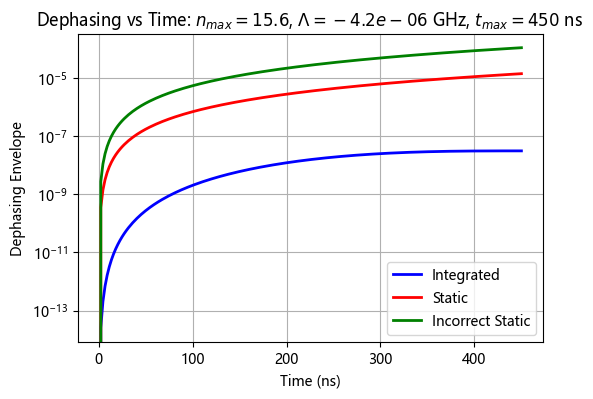

In [3]:
def integrated_sin2(t, t_max, n_max):
    """
    Return the integral from 0 to t of n_max * sin^2(pi*t'/t_max) dt'.
    """
    alpha = np.pi / t_max
    # Integral of sin^2(alpha*x) dx = x/2 - sin(2 alpha x)/(4 alpha)
    return n_max * (t/2.0 - np.sin(2.0 * alpha * t) / (4.0 * alpha))

def static_dephasing_envelope(t, lambda_val, n_max):
    return 1-np.exp(-0.5*(lambda_val*t)**2*n_max/2)

def incorrect_static_dephasing_envelope(t, lambda_val, n_max):
    return 1-np.exp(-0.5*(lambda_val*t*n_max/2)**2)

def integrated_dephasing_envelope(t, lambda_val, t_max, n_max):
    """
    Compute the dephasing envelope at time t under the integral model:
      exp( - 1/2 * lambda_val^2 * integral_0^t [ n_max * sin^2(...) ] dt' ).
    """
    # 1) Compute the integral of the mean photon number from 0 to t
    photon_integral = integrated_sin2(t, t_max, n_max)
    # 2) Multiply by lambda_val^2 / 2 with a minus sign
    exponent = -0.5 * (lambda_val**2) * photon_integral
    return 1-np.exp(exponent)

def plot_dephasing(lambda_val, n_max, t_max, num_points=200):
    t_array = np.linspace(0, t_max, num_points)
    # Calculate dephasing envelope for each time
    integrated_envelope = [integrated_dephasing_envelope(t, lambda_val, t_max, n_max) for t in t_array]
    static_envelope = [static_dephasing_envelope(t, lambda_val, n_max) for t in t_array]
    incorrect_static_envelope = [incorrect_static_dephasing_envelope(t, lambda_val, n_max) for t in t_array]
    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(t_array, integrated_envelope, 'b-', linewidth=2)
    plt.plot(t_array, static_envelope, 'r-', linewidth=2)
    plt.plot(t_array, incorrect_static_envelope, 'g-', linewidth=2)
    plt.legend(['Integrated', 'Static', 'Incorrect Static'])
    plt.yscale('log') 
    # plt.ylim(1e-10,np.max(envelope))
    plt.xlabel('Time (ns)')
    plt.ylabel('Dephasing Envelope')
    plt.title(rf'Dephasing vs Time: $n_{{max}}={n_max}$, $\Lambda={lambda_val}$ GHz, $t_{{max}}={t_max}$ ns')
    plt.grid(True)
    plt.show()

plot_dephasing(-4.2 *1e-6, 15.6, 450, num_points=200)

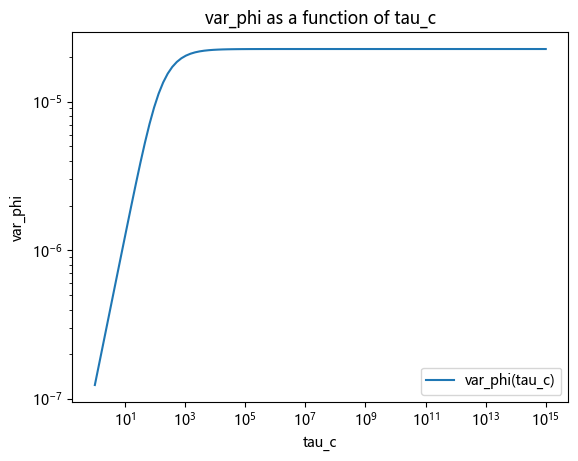

In [4]:
def nbar(t, nmax, tmax):
    """
    Mean photon number at time t,
    following nmax * sin^2(pi t / tmax).
    """
    return nmax * np.sin(np.pi * t / tmax)**2

def K(t1, t2, nmax, tmax, tau_c):
    """
    Ornstein-Uhlenbeck-like correlation function
    for the photon-number fluctuations δn(t).
    """
    # The local amplitude is sqrt(nbar(t1) * nbar(t2))
    # The exponential sets the correlation time tau_c
    return np.sqrt(nbar(t1, nmax, tmax) * nbar(t2, nmax, tmax)) \
           * np.exp(-abs(t1 - t2) / tau_c)

def compute_dephasing(nmax, tmax, Lambda, tau_c, num_points=2000):
    """
    Numerically integrate to get:
      mean_phi = Λ * ∫ nbar(t) dt
      var_phi  = Λ^2 * ∫∫ K(t1, t2) dt1 dt2
    Return coherence = exp(i * mean_phi - 0.5 * var_phi).
    """
    # 1) Set up the time grid
    ts = np.linspace(0, tmax, num_points)
    dt = ts[1] - ts[0]

    # 2) Compute mean_phi by 1D integral of nbar(t)
    nbar_vals = nbar(ts, nmax, tmax)
    mean_phi = Lambda * np.trapz(nbar_vals, ts)

    # 3) Compute the 2D array for K(t1, t2) using vectorized operations
    t1, t2 = np.meshgrid(ts, ts, indexing='ij')
    Kvals = np.sqrt(nbar(t1, nmax, tmax) * nbar(t2, nmax, tmax)) \
            * np.exp(-np.abs(t1 - t2) / tau_c)

    # 2D numerical integration using vectorized trapz
    var_phi = Lambda**2 * np.trapz(np.trapz(Kvals, dx=dt, axis=0), dx=dt)

    # 4) Coherence factor = exp(i * mean_phi - 0.5 * var_phi)
    coherence = np.exp(1j * mean_phi - 0.5 * var_phi)

    return coherence, mean_phi, var_phi

# Example parameters
nmax   = 15.6    # maximum average photon number
tmax   = 450    # total time
Lambda = 4.2 *1e-6    # coupling strength
# tau_c  = 10.0    # correlation time
num_points = 2000

tau_c_values = np.logspace(0, 15, 100)

# Initialize a list to store var_phi for each tau_c
var_phi_values = []

# Compute var_phi for each tau_c
for tau_c in tau_c_values:
    _, _, var_phi = compute_dephasing(nmax, tmax, Lambda, tau_c, num_points)
    var_phi_values.append(var_phi)

# Plot var_phi as a function of tau_c
plt.plot(tau_c_values, var_phi_values, label='var_phi(tau_c)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('tau_c')
plt.ylabel('var_phi')
plt.title('var_phi as a function of tau_c')
plt.legend()
plt.show()

In [8]:
nmax   = 20    # maximum average photon number
tmax   = 347    # total time
Lambda = 3.1 *1e-5    # coupling strength
# tau_c  = 10.0    # correlation time
num_points = 2000
tau_c = 1e9

_, _, var_phi = compute_dephasing(nmax, tmax, Lambda, tau_c, num_points)
var_phi

0.0009379341795416259

In [7]:
nmax   = 15.6    # maximum average photon number
tmax   = 450    # total time
Lambda = 4.2 *1e-6    # coupling strength
# tau_c  = 10.0    # correlation time
num_points = 2000
tau_c = 1e9
_, _, var_phi = compute_dephasing(nmax, tmax, Lambda, tau_c, num_points)
var_phi

2.2584382728045378e-05

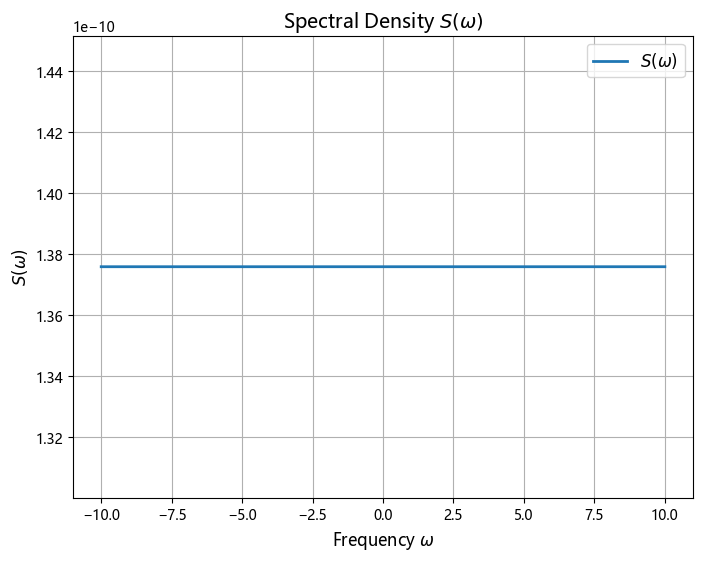

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
n_max = 15.6
Lambda = 4.2e-6
t_max = 450

# Frequency range for S(omega)
omega = np.linspace(-10, 10, 10000000)

# Function to compute the spectral density
def spectral_density(omega, n_max, Lambda, t_max):
    # Define the trigonometric terms
    prefactor = (Lambda ** 2) * n_max / 2
    cosine_term = np.cos(np.pi * omega / t_max)
    sine_term = np.sin(np.pi * omega / t_max)

    # Compute the spectral density
    S_omega = prefactor * (cosine_term ** 2 + sine_term ** 2)
    return S_omega

# Compute S(omega)
S_omega = spectral_density(omega, n_max, Lambda, t_max)

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(omega, S_omega, label=r"$S(\omega)$", linewidth=2)
plt.title("Spectral Density $S(\omega)$", fontsize=14)
plt.xlabel(r"Frequency $\omega$", fontsize=12)
plt.ylabel(r"$S(\omega)$", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()
